In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import pandas as pd

In [3]:
image_path = fr"C:\Users\surri\PycharmProjects\ML_Assignment2\image.jpg" 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image 

In [4]:
image.shape

(480, 640)

In [5]:
x, y = (240,120)
patch_size = 50
patch = image[y:y+patch_size, x:x+patch_size]
# org_patch = patch
# img = cv2.rectangle(image, (x, y), (x + patch_size, y + patch_size), (255, 255, 0), 5)

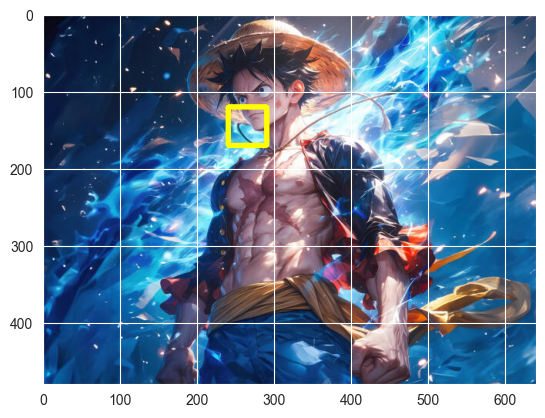

In [15]:
plt.imshow(img)

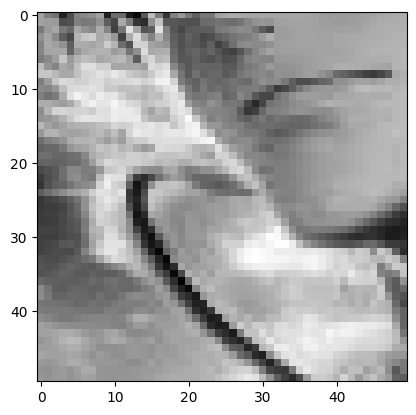

In [15]:
plt.imshow(patch,cmap='gray')

Let us decompose org_patch as WH. W is of shape (50, r) and H is of shape (r, 50). We can write the above equation as:
A = WH

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
r = 10
W = np.random.randint(low = 0, high = 16,size = (50, r))
H = np.random.randint(low = 0, high = 16,size = (r, 50))
W = torch.from_numpy(W).to(device).float()
H = torch.from_numpy(H).to(device).float()
patch = torch.from_numpy(patch)
patch = patch.to(device)

# Compute the loss
with torch.no_grad():
    loss = torch.norm(torch.mm(W, H) - patch)
    print(loss)

tensor(21330.8008, device='cuda:0')


In [8]:
pd.DataFrame(torch.mm(W, H).cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,945.0,892.0,962.0,545.0,639.0,769.0,909.0,982.0,729.0,1221.0,...,828.0,827.0,920.0,482.0,708.0,750.0,782.0,508.0,578.0,824.0
1,634.0,547.0,676.0,338.0,389.0,604.0,641.0,679.0,650.0,894.0,...,630.0,747.0,650.0,346.0,543.0,551.0,627.0,348.0,451.0,708.0
2,509.0,520.0,453.0,295.0,314.0,400.0,432.0,595.0,382.0,564.0,...,445.0,387.0,481.0,288.0,253.0,284.0,405.0,187.0,317.0,370.0
3,735.0,610.0,744.0,400.0,456.0,450.0,529.0,700.0,479.0,868.0,...,464.0,531.0,623.0,365.0,363.0,540.0,509.0,270.0,440.0,588.0
4,633.0,631.0,620.0,391.0,419.0,599.0,571.0,768.0,452.0,765.0,...,654.0,472.0,578.0,382.0,501.0,377.0,510.0,340.0,411.0,518.0


In [9]:
pd.DataFrame(patch.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,171,141,131,66,102,146,151,156,169,65,...,166,166,166,167,169,172,175,177,178,179
1,171,167,164,100,104,143,138,140,158,114,...,165,166,167,169,172,175,178,180,179,180
2,137,164,175,137,125,175,158,149,179,149,...,169,170,171,172,175,178,180,182,181,182
3,157,173,151,115,96,185,200,207,177,184,...,175,175,176,177,178,179,180,181,183,184
4,145,176,170,157,116,180,179,173,180,206,...,174,175,177,179,180,182,183,183,185,186


In [10]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features
    
    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    
    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

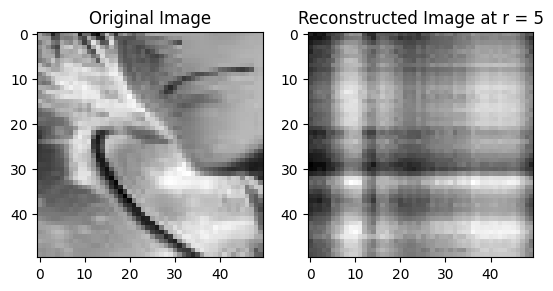

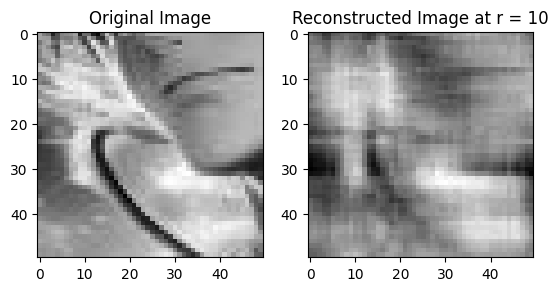

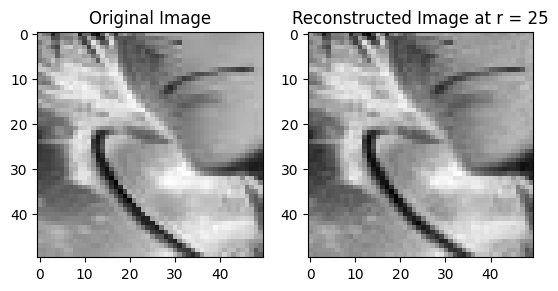

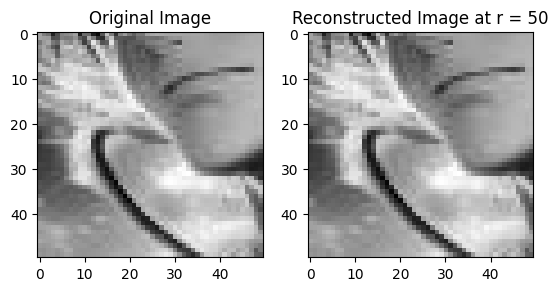

In [11]:
results = []
for k in [5,10,25,50]:
    W, H, loss = factorize(patch, k, device=device)
    plt.subplot(1, 2, 1)
    plt.imshow(patch.cpu().detach().numpy(),cmap = "gray")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow((W@H).cpu().detach().numpy(),cmap = "gray")
    plt.title(f"Reconstructed Image at r = {k}")
    rmse = torch.sqrt(loss).mean()
    psnr = 10 * torch.log10(255.0 / loss.mean())
    results.append([k, rmse, psnr])
    plt.show()

In [13]:
for i in results:
    print(f"For r = {i[0]}, RMSE = {i[1].cpu().detach().numpy()}, PSNR = {i[2].cpu().detach().numpy()}")

For r = 5, RMSE = 41.314762115478516, PSNR = -8.25670337677002
For r = 10, RMSE = 32.59513473510742, PSNR = -6.197654724121094
For r = 25, RMSE = 15.436542510986328, PSNR = 0.2944011688232422
For r = 50, RMSE = 2.407212018966675, PSNR = 16.43511390686035
